# US Housing Market Analysis

In [74]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from kaleido.scopes.plotly import PlotlyScope
from bokeh.io import export_png
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Loading and cleaning data
We will be using data from [FRED](https://fred.stlouisfed.org/), the Federal Reserve Economic Data, and [AlphaVantage](https://www.alphavantage.co/), a free API for stock market data. The data collected from AlphaVantage is mostly commodity prices, and the data from FRED is mostly economic indicators. 

In [75]:
# Read in data
file_path = Path("data/housing_data3.csv")
df = pd.read_csv(file_path)
df.head()

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
0,1987-01-01,63.734,6.0,1690.0,90.4,1090.0,1774.0,108.1,58585,125.90971,1862.0,97900.0,18.65,111.2,6.43,384.227143,-0.506
1,1987-02-01,64.134,6.2,1689.0,90.2,1096.0,1784.0,109.4,53102,124.24761,1771.0,97900.0,17.75,111.6,6.10,411.712632,-0.495
2,1987-03-01,64.469,6.0,1704.0,90.8,1084.0,1726.0,110.6,43500,123.59781,1694.0,97900.0,18.30,112.1,6.13,432.204545,-0.335
3,1987-04-01,64.973,6.0,1601.0,92.8,1079.0,1614.0,110.7,54405,134.50752,1735.0,103400.0,18.68,112.7,6.37,422.771429,0.105
4,1987-05-01,65.547,6.7,1500.0,91.1,1070.0,1628.0,110.7,65151,144.95212,1713.0,103400.0,19.44,113.1,6.85,416.634000,0.540


In [76]:
df.tail()

,Date,Price Index,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Sales Price,Oil Price,CPI,Fed Funds Rate,NASDAQ,NFCI
428,2022-09-01,300.451,9.7,1588.0,58.6,1698.0,1463.0,322.849,72386,83.61149,1438.0,468000.0,84.26,296.81,2.56,11402.850000,-0.1320
429,2022-10-01,298.672,9.7,1555.0,59.9,1710.0,1432.0,317.617,65599,94.39124,1348.0,479500.0,87.55,298.01,3.08,10801.494286,-0.0925
430,2022-11-01,296.809,9.4,1402.0,56.8,1695.0,1427.0,312.864,55272,93.09166,1543.0,479500.0,84.37,297.71,3.78,10973.638095,-0.1725
431,2022-12-01,294.266,8.5,1409.0,59.7,1696.0,1357.0,308.076,47749,87.05882,1390.0,479500.0,76.44,296.80,4.10,10838.995714,-0.1960
432,2023-01-01,292.444,8.1,1354.0,64.9,1695.0,1340.0,306.461,40292,85.80711,1377.0,436800.0,78.12,299.17,4.33,11013.991000,-0.2825


# Defining the feature and target variables

In [77]:
# Define features set
X = df.copy()
X = X.drop("Date", axis=1)
X = X.drop("Price Index", axis=1)
X = X.drop("Sales Price", axis=1)
X = X.drop("CPI", axis=1)
# drop first row
X = X.iloc[1:]
X.head()

,Monthly Supply,Permits,Sentiment Index,Construction,Housing Starts,Lumber Price Index,Pair Count,Mortgage Rate,Units Completed,Oil Price,Fed Funds Rate,NASDAQ,NFCI
1,6.2,1689.0,90.2,1096.0,1784.0,109.4,53102,124.24761,1771.0,17.75,6.10,411.712632,-0.495
2,6.0,1704.0,90.8,1084.0,1726.0,110.6,43500,123.59781,1694.0,18.30,6.13,432.204545,-0.335
3,6.0,1601.0,92.8,1079.0,1614.0,110.7,54405,134.50752,1735.0,18.68,6.37,422.771429,0.105
4,6.7,1500.0,91.1,1070.0,1628.0,110.7,65151,144.95212,1713.0,19.44,6.85,416.634000,0.540
5,6.9,1522.0,91.5,1060.0,1594.0,111.4,75404,144.15185,1635.0,20.07,6.73,423.695909,0.500


In [78]:
# checking the shape of X and if there are any null values
print(X.shape)
print(X.isnull().sum())

(432, 13)
Monthly Supply        0
Permits               0
Sentiment Index       0
Construction          0
Housing Starts        0
Lumber Price Index    0
Pair Count            0
Mortgage Rate         0
Units Completed       0
Oil Price             0
Fed Funds Rate        0
NASDAQ                0
NFCI                  0
dtype: int64


# Creating the target vector 
Price Index = S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted)

In [79]:
# Define target vector 'Price Change' as y
y = df["Price Index"].values.reshape(-1, 1)
y = y[1:]
y[:5]

array([[64.134],
       [64.469],
       [64.973],
       [65.547],
       [66.218]])

# Splitting the data into training and testing sets

In [80]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)


In [81]:
# Create a StandardScaler instance
scaler = StandardScaler()

In [82]:
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

In [83]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_test_scaled.shape

(108, 13)

# Fitting the Random Forest model

Having scaled the data, we can now fit the Random Forest model to the training data.

In [84]:
# create the random forrest classifier instance
rf_model = RandomForestRegressor(n_estimators=200, random_state=78)
# fit the model
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

# Making predictions with the Random Forest model

In [85]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)
predictions

array([108.759375, 279.16533 ,  92.44938 , 163.32949 , 149.651955,
       123.60015 , 149.821735, 169.374775,  79.815105,  87.528185,
        82.494995,  76.576725, 159.87978 ,  76.53093 ,  77.35861 ,
       129.661515, 238.261475,  76.48637 ,  67.42809 ,  76.517515,
       117.76461 , 300.46339 ,  78.772805, 143.77012 , 214.3335  ,
       144.59124 , 168.974205, 194.507505, 142.79523 ,  97.326845,
       150.824935, 155.21526 , 250.86102 ,  83.025525, 149.2741  ,
       185.35313 , 302.47616 ,  76.6202  ,  79.75519 , 102.99005 ,
       149.415105, 130.028425,  79.881675, 210.839095,  95.076755,
        73.86898 ,  93.57545 , 182.3228  , 145.423355, 176.9818  ,
        67.72251 , 166.311685, 198.852545, 199.689465, 142.396645,
        72.8241  , 153.92091 , 123.88471 , 233.40103 ,  69.965345,
       164.660475, 170.226265, 169.36153 ,  76.35782 ,  72.64672 ,
       171.473835,  66.08021 ,  89.420995, 138.190575,  76.474275,
       171.999   ,  94.98399 , 139.39312 , 141.46485 , 171.540

In [86]:
# compare predictions to actual values
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")


First 10 Predictions:   [108.759375 279.16533   92.44938  163.32949  149.651955 123.60015
 149.821735 169.374775  79.815105  87.528185]
First 10 Actual labels: [[109.214], [276.07], [90.194], [164.278], [148.17], [123.68700000000001], [147.96], [182.472], [80.339], [86.31]]


# Evaluating the Random Forest model

In [87]:
# chart of predictions vs actual
results_df = pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()})
# change the datatypes to float
results_df = results_df.astype("float64")
# add a column for the difference between the prediction and actual
results_df["Difference"] = results_df["Actual"] - results_df["Prediction"]
# add a column for the percent difference between the prediction and actual
results_df["Percent Difference"] = results_df["Difference"] / results_df["Actual"] * 100
# find the highest percent difference
results_df["Percent Difference"].max()
results_df.head(10)

,Prediction,Actual,Difference,Percent Difference
0,108.759375,109.214,0.454625,0.416270
1,279.165330,276.070,-3.095330,-1.121212
2,92.449380,90.194,-2.255380,-2.500588
3,163.329490,164.278,0.948510,0.577381
4,149.651955,148.170,-1.481955,-1.000172
5,123.600150,123.687,0.086850,0.070218
6,149.821735,147.960,-1.861735,-1.258269
7,169.374775,182.472,13.097225,7.177663
8,79.815105,80.339,0.523895,0.652105
9,87.528185,86.310,-1.218185,-1.411407


In [98]:
# use plotly express to create a histogram of the percent difference
fig = px.histogram(results_df, x="Percent Difference", title="Percent Difference Between Prediction and Actual")
fig.show()

In [100]:
# save the plot as a png file
scope = PlotlyScope()
with open("images/percent_difference_custom.png", "wb") as f:
    f.write(scope.transform(fig, format="png"))
    

In [88]:
# calculate the mean absolute error (MAE)
mae = results_df["Difference"].mean()
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: -0.148862500000007


In [89]:
# calculate the mean squared error (MSE)
mse = results_df["Difference"].apply(lambda x: x**2).mean()
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 13.742299149847925


In [90]:
# calculate the root mean squared error (RMSE)
rmse = mse**(0.5)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 3.7070607156948383


In [91]:
# calculate the mean absolute percent error (MAPE)
mape = results_df["Percent Difference"].abs().mean()
print(f"Mean Absolute Percent Error: {mape}")


Mean Absolute Percent Error: 1.361249352798155


In [92]:
# score the model
rf_model.score(X_test_scaled, y_test)

0.9959611673210985

# Feature importance

In [93]:
# get the feature importance array
importances = rf_model.feature_importances_
# list of features
feature_list = list(X.columns)
# sort the features by their importance
sorted(zip(rf_model.feature_importances_, feature_list), reverse=True)
# print the feature importance
for feature in zip(feature_list, rf_model.feature_importances_):
    print(f"{feature[0]}: ({feature[1]})")
    

Monthly Supply: (0.0033187426539476334)
Permits: (0.004366599288078427)
Sentiment Index: (0.006384665517983358)
Construction: (0.028602335202134434)
Housing Starts: (0.00574151989130087)
Lumber Price Index: (0.3943630803264192)
Pair Count: (0.0006777755426412739)
Mortgage Rate: (0.1937878725714882)
Units Completed: (0.0015334711323964903)
Oil Price: (0.15038255825384655)
Fed Funds Rate: (0.037865016078313364)
NASDAQ: (0.16938625057022866)
NFCI: (0.0035901129712217756)


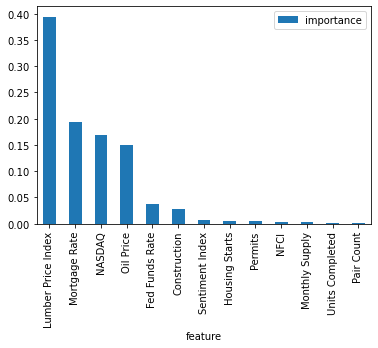

In [94]:
# add the feature importance to a dataframe
feature_importance_df = pd.DataFrame({"feature": feature_list, "importance": importances})
# sort the dataframe by the importance
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)
# set the index to be the feature
feature_importance_df = feature_importance_df.set_index("feature", drop=True)
# plot the feature importance
feature_importance_df.plot(kind="bar")
plt.show()

In [95]:
# use plotly to create a bar chart of the feature importance
fig = px.bar(feature_importance_df, x=feature_importance_df.index, y="importance", title="Feature Importance", color="importance", color_continuous_scale=px.colors.sequential.Cividis_r)
# save the plot as a png file
fig.write_image("images/feature_importance_custom.png")
# show the plot
fig.show()

In [96]:
# define a function to output images of tables
def save_df_as_image(df, filename):
    source = ColumnDataSource(df)
    columns = [TableColumn(field=Ci, title=Ci) for Ci in df.columns]  # bokeh columns
    # add index column
    columns.insert(0, TableColumn(field="index", title="index"))
    # use df index as index column
    source.add(df.index, "index")
    data_table = DataTable(columns=columns, source=source, width=800, height=280)
    export_png(data_table, filename=filename)

In [97]:
# save a table of the feature importance
save_df_as_image(feature_importance_df, "images/feature_importance_custom_table.png")